# Linear and Logistic Regression with Keras

## Setup

In [79]:
# Note: a "dependency resolver" error may occur here; ignore it.
!pip list | egrep 'keras|tensorflow |torch '
!pip install -U keras

keras                                    3.0.5
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6
tensorflow                               2.15.0
torch                                    2.1.2


In [80]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
print("Keras", keras.__version__, 'on', keras.backend.backend())
assert keras.__version__.startswith('3'), "Somehow got Keras 2; try stopping and restarting the session"
import numpy as np
np.set_printoptions(precision=3)
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

def show_weight_images(linear_layer):
    weights, bias = linear_layer.get_weights()
    weight_images = weights.T.reshape(-1, 28, 28)
    if weight_images.shape[0] == 10:
        nrow, ncol = 2, 5
    else:
        nrow, ncol = 1, 1
    with matplotlib.rc_context(rc={'image.cmap': 'RdBu'}):
        vmax = np.abs(weight_images).max()
        fig, axs = plt.subplots(nrow, ncol, squeeze=False)
        for i, ax in enumerate(axs.flatten()):
            ax.imshow(weight_images[i], vmax=vmax, vmin=-vmax)
            ax.set(title=f'{i}')
            ax.axis('off')

Keras 3.0.5 on torch


# Data Loading

In [81]:
from keras.datasets import mnist

DATASET = 'mnist'

if DATASET == 'toy':
    x = np.array([0, 1, 2, 3])[:, np.newaxis]
    y_true = np.array([-1, .5, 2.0, 3.5])[:, np.newaxis]
if DATASET == 'toy2':
    x = np.array([0, 1, 2, 3])[:, np.newaxis]
    y_true = np.array([-1, .5, 2.0, 25])[:, np.newaxis]
elif DATASET == "temps":
    data = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", skiprows=1)
    # Shape x to be items-by-features
    x = data.iloc[:, 0].values.astype(np.float32)[:, np.newaxis]
    # scale x to a reasonable range
    x -= 1880.0
    x /= 100.
    y_true = data.iloc[:, 1].values.astype(np.float32)[:, np.newaxis]
elif DATASET == 'mnist':
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    train_images = train_images.reshape((60000, 28 * 28))
    train_images = train_images.astype("float32") / 255
    test_images = test_images.reshape((10000, 28 * 28))
    test_images = test_images.astype("float32") / 255
    
    # Rename to match the convention of our notebook
    x, y_true = train_images, train_labels
    del train_images, train_labels
else:
    raise Exception("Unknown dataset")

Show the data (or an example item from it)

x shape (60000, 784) y_true shape (60000,)


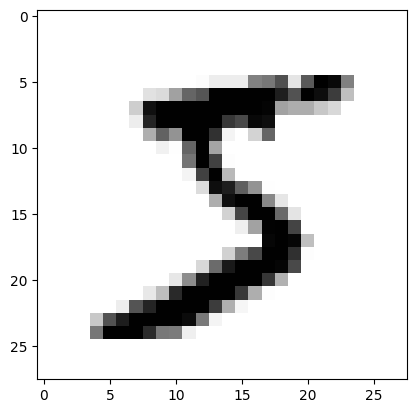

In [82]:
if len(x) < 50:
    plt.scatter(x, y_true)
elif x.shape[1] == 1:
    plt.plot(x, y_true)
else:
    with matplotlib.rc_context(rc={'image.cmap': 'gray_r'}):
        plt.imshow(x[0].reshape(28, 28))
print("x shape", x.shape, "y_true shape", y_true.shape)

# Train and Evaluate Model

In [83]:
y_true_onehot = keras.utils.to_categorical(y_true, num_classes=10)
print('one hot shape', y_true_onehot.shape)
print('one hot example:')
print(y_true_onehot[:5])

one hot shape (60000, 10)
one hot example:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [84]:
model = keras.Sequential([
    keras.layers.Input(shape=(784,)),
    #keras.layers.Dense(800, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss='crossentropy',
    metrics=['accuracy']
)
history = model.fit(x, y_true_onehot, epochs=5, validation_split=.25)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8912 - loss: 0.3591 - val_accuracy: 0.9627 - val_loss: 0.1229
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9699 - loss: 0.0989 - val_accuracy: 0.9717 - val_loss: 0.0988
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9822 - loss: 0.0586 - val_accuracy: 0.9737 - val_loss: 0.0936
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9884 - loss: 0.0390 - val_accuracy: 0.9733 - val_loss: 0.1085
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9901 - loss: 0.0306 - val_accuracy: 0.9748 - val_loss: 0.0986


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Final Loss: 0.031, final weights: (800, 10), final bias: [-0.148 -0.093 -0.085  0.033 -0.068 -0.041 -0.145 -0.073  0.084 -0.034]


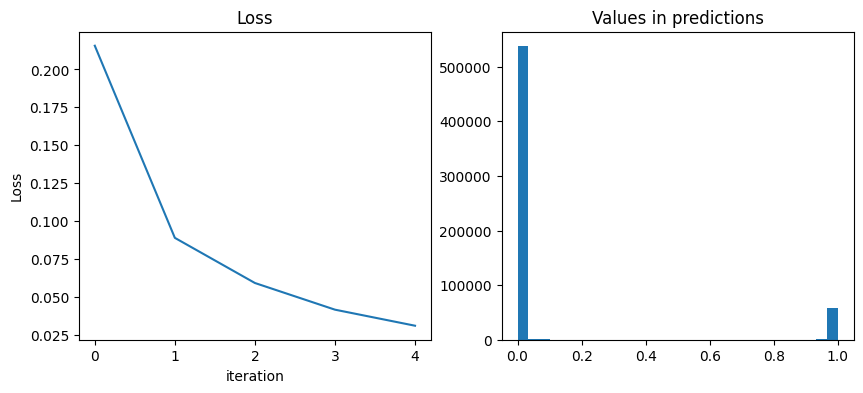

In [85]:
# Extract results from Keras
y_pred = model.predict(x)
losses = history.history['loss']
linear_layer = model.layers[-1]
weights, bias = linear_layer.get_weights()
# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(losses)
axs[0].set(title="Loss", xlabel="iteration", ylabel="Loss")
if x.shape[1] == 1:
    axs[1].scatter(x, y_true)
    axs[1].plot(x, y_pred, 'r');
    axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
else:
    axs[1].hist(y_pred.flatten(), bins=30)
    axs[1].set(title="Values in predictions")
print(f"Final Loss: {losses[-1]:.3f}, final weights: {weights.flatten() if len(weights.flatten()) < 25 else weights.shape}, final bias: {bias}")

In [86]:
show_weight_images(linear_layer)

ValueError: cannot reshape array of size 8000 into shape (28,28)

In [ ]:
probs = model.predict(x[0:1])
plt.barh(np.arange(10), probs[0])

# Analysis

Step 2

accuracy: 0.1292 - loss: 6.5265 - val_accuracy: 0.1457 - val_loss: 3.6217

accuracy: 0.1462 - loss: 3.6818 - val_accuracy: 0.1377 - val_loss: 3.4297

accuracy: 0.1455 - loss: 3.5168 - val_accuracy: 0.1403 - val_loss: 3.3360

accuracy: 0.1433 - loss: 3.4765 - val_accuracy: 0.1387 - val_loss: 3.2971

accuracy: 0.1402 - loss: 3.3857 - val_accuracy: 0.1441 - val_loss: 3.3101

Step 4

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7899 - loss: 0.0344 - val_accuracy: 0.9061 - val_loss: 0.0147
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9094 - loss: 0.0145 - val_accuracy: 0.9131 - val_loss: 0.0134
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9172 - loss: 0.0130 - val_accuracy: 0.9180 - val_loss: 0.0128
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9220 - loss: 0.0125 - val_accuracy: 0.9211 - val_loss: 0.0123
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9214 - loss: 0.0122 - val_accuracy: 0.9212 - val_loss: 0.0122
add Codeadd Markdown

The activation='softmax' function is used in the output layer of a multi-class classification model to convert the output of the model into a probability distribution over the classes. It ensures that the sum of all the predicted probabilities is equal to 1.

For example, if the output of the model is a vector [0.2, 0.3, 0.5], then the softmax function will convert it into a probability distribution [0.15, 0.19, 0.66], where the last element has the highest probability of being the correct class.

The softmax activation function also affects the loss function used in the model. In the case of multi-class classification, the categorical cross-entropy loss function is typically used. The categorical cross-entropy loss function is defined as:

$L = - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^C y_{ij} \log(\hat{y}_{ij})$

where $N$ is the number of samples, $C$ is the number of classes, $y_{ij}$ is the true label for the $i$th sample and $j$th class, and $\hat{y}_{ij}$ is the predicted probability for the $i$th sample and $j$th class.

The softmax activation function ensures that the predicted probabilities are non-negative and sum to 1, which allows the categorical cross-entropy loss function to be well-defined. The categorical cross-entropy loss function measures the difference between the predicted probability distribution and the true probability distribution, and the model tries to minimize this difference during training.

In summary, the activation='softmax' function converts the output of the model into a probability distribution over the classes, and it affects the loss function used in the model by allowing the use of the categorical cross-entropy loss function, which measures the difference between the predicted probability distribution and the true probability distribution.

# Step 5

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8070 - loss: 0.7402 - val_accuracy: 0.9091 - val_loss: 0.3216
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9098 - loss: 0.3184 - val_accuracy: 0.9187 - val_loss: 0.2974
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9181 - loss: 0.2914 - val_accuracy: 0.9211 - val_loss: 0.2948
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9202 - loss: 0.2860 - val_accuracy: 0.9215 - val_loss: 0.2907
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9211 - loss: 0.2884 - val_accuracy: 0.9227 - val_loss: 0.2888

# Step 6

In [ ]:
weights, bias = linear_layer.get_weights()
logits = np.dot(test_images, weights) + bias
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

test_predicted_probs = softmax(logits)
test_predicted_probs = np.array(test_predicted_probs)

print("Shape of test_predicted_probs:", test_predicted_probs.shape)


10000 -> the number of test images in the MNIST dataset. There are 10,000 test images -> size of 10,000.

10 ->  the number of classes in the MNIST dataset. 10 classes corresponding to digits from 0 to 9 -> size of 10.

In [ ]:
test_predictions = np.argmax(test_predicted_probs, axis=1)
print("Shape of test_predictions:", test_predictions.shape)

The shape indicates that test_predictions is a one-dimensional array. The size matches the number of test images in the MNIST dataset. Each element in this array represents the predicted class for the corresponding test image. 

In [ ]:
correct_predictions = test_predictions == test_labels
accuracy = np.mean(correct_predictions)
error_rate = 100 - accuracy * 100

print("Accuracy:", accuracy)
print("Error rate:", error_rate)


# Step 7

# Analysis Table

The validation loss and acurracy can be find above. 

| Model Description                    | Prediction Equation | Weights shape | Biases shape | Loss Function | Validation Loss | Validation Accuracy |
|------------------------------------|----------------------|---------------|--------------|----------------|-----------------|----------------------|
| Linear regression (one number output) | `y = x @ W + b` | (784, 1) | (1,) | MSE | | |
| Linear regression (10 number output) | `y = x @ W + b` | (784, 1)  | (10,)  | MSE | | |
| Logistic regression | `y = x @ W + b` | (784, 1) | (10,) | crossentropy | | |
| Going Deeper | `y = x @ W + b` |(784, 1) | (800,10) | crossentropy | | |

## Narative

2. Linear Regression (10 number output)
* Describe how its training setup was different from the prior one, the difference is the 10 output. 
* Describe why that difference should lead to an improvement in the results, it might lead to improvement of the validacy accurancy because, the other digits can be seen better. So the overall performance would increase. 
* Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model.
* Describe how its accuracy differs from the previous one: The accuracy increased. 

3. Logistic regression 
* Describe how its training setup was different from the prior one: this training setup is different because it uses a different loss function. 
* Describe why that difference should lead to an improvement in the results: it can improve through the behavior of gradients during optimization, and its ability to handle class imbalance and produce wellprobability predictions.
* Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model.
* Describe how its accuracy differs from the previous one: The accuracy increased. 

4. Going Deeper 
* Describe how its training setup was different from the prior one: It adds another layer of dense and added activation relu on it. 
* Describe why that difference should lead to an improvement in the results: It should lead to an improvement in the performance of a neural network by introducing non-linearity to the model which allows the model to learn non-linear relationships in the data, which can be useful for complex tasks. 
* Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model: I was stuck during this phase and could not computate the predictions. 
* Describe how its accuracy differs from the previous one.

## General Questions

1. How is the softmax operation useful in classification? it converts the output of a neural network into a probability distribution over the possible classes. This allows us to interpret the output of the network as a probability that the input belongs to a certain class.

2. Suppose an interviewer asks you “What’s the difference between linear regression and logistic regression?” Describe at least two differences you could mention.

Linear regression: Uses MSE loss function. Predicts continuous values.

Logistic Regression: Uses the cross-entropy loss function. Predict Binary.

3. The weight images helped us see that even though some of the models were getting good accuracy, they were doing so for the wrong reasons. Consider the weight images for the logistic regression model (Step 5). Why did the weights look vaguely like the digits? Why did the weights look not exactly like the digits? I think the reason that they look vaguely like the digits is because the weights are trying to identify the patterns in the data. The weights are essentially the parameters of the logistic regression model, and they are learned by the model during training. The weight images show the learned patterns in the data. I think that the model is not just memorizing the training data, but is also trying to learn an unseen data of patterns. 